# Part 3. Explore and cluster the neighborhoods in Toronto.
TODOS:

Explore neighborhoods in Toronto

Cluster Neighborhoods

Examine Clusters




In [1]:
import pandas as pd
import numpy as np
import folium
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kneed import KneeLocator

from datetime import datetime

#### Define Foursquare Credentials and Version

In [2]:
%run webassets.py #load CLIENT_ID and CLIENT_SECRET from file webassets.py
# CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
# CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = datetime.now().strftime('%Y%m%d') # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

## 1. Explore neighborhoods in Toronto

In this section, we will create a map of Toronto with superimposed on top and then we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


### Load DataFrame `toronto_neighborhoods` by running previous part of this project

In [3]:
%run 'part2-Segmenting and Clustering Neighborhoods in Toronto.ipynb'


Read HTML tables in Wikipedia URL : 
▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

Number of tables: 3

First row of Table 0:
                 0                1                         2
0  M1ANot assigned  M2ANot assigned  M3ANorth York(Parkwoods)

First row of Table 1:
     0                      1    2
0  NaN  Canadian postal codes  NaN

First row of Table 2:
    0   1   2
0  NL  NS  PE

First few rows of the DataFrame df:
  PostalCode      Borough                            Neighborhood
0        M1B  Scarborough                          Malvern, Rouge
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae
Shape of df: (103, 3)
First few rows of DataFrame `toronto_neighborhoods`:
  PostalCode      Borough                            Neighbor

### Use geopy library to get the latitude and longitude values of Toronto.

In [4]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Create a map of Toronto with neighborhoods superimposed on top.

In [5]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_neighborhoods['Latitude'], 
                                           toronto_neighborhoods['Longitude'], 
                                           toronto_neighborhoods['Borough'], 
                                           toronto_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Get venues in each neighborhoods of Toronto

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    '''
        This function return a DataFrame of near-by revenue from a list of names, latitudes and longitudes
    '''
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(f'Getting venue near by {name} (radius: {radius}m){"."*10}')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        if len(results) in (0, 1) :
            print(f'\tGet {len(results)} venue')
        else:
            print(f'\tGet {len(results)} venues')
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood Name', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print(f'Total venue: {len(nearby_venues)}')
    return(nearby_venues)

In [7]:
toronto_venues = getNearbyVenues(names=toronto_neighborhoods['Neighborhood'],
                                   latitudes=toronto_neighborhoods['Latitude'],
                                   longitudes=toronto_neighborhoods['Longitude'],
                                   radius=600
                                  )

Getting venue near by Malvern, Rouge (radius: 600m)..........
	Get 4 venues
Getting venue near by Rouge Hill, Port Union, Highland Creek (radius: 600m)..........
	Get 2 venues
Getting venue near by Guildwood, Morningside, West Hill (radius: 600m)..........
	Get 17 venues
Getting venue near by Woburn (radius: 600m)..........
	Get 4 venues
Getting venue near by Cedarbrae (radius: 600m)..........
	Get 15 venues
Getting venue near by Scarborough Village (radius: 600m)..........
	Get 4 venues
Getting venue near by Kennedy Park, Ionview, East Birchmount Park (radius: 600m)..........
	Get 7 venues
Getting venue near by Golden Mile, Clairlea, Oakridge (radius: 600m)..........
	Get 13 venues
Getting venue near by Cliffside, Cliffcrest, Scarborough Village West (radius: 600m)..........
	Get 4 venues
Getting venue near by Birch Cliff, Cliffside West (radius: 600m)..........
	Get 6 venues
Getting venue near by Dorset Park, Wexford Heights, Scarborough Town Centre (radius: 600m)..........
	Get 11 v

In [8]:
toronto_venues.shape

(2775, 7)

In [9]:
toronto_venues.head()

,Neighborhood Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
1,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
2,"Malvern, Rouge",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
3,"Malvern, Rouge",43.806686,-79.194353,Lee Valley,43.803161,-79.199681,Hobby Shop
4,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping


### Let's check how many venues were returned for each neighborhood

In [10]:
toronto_venues[['Neighborhood Name', 'Venue']].groupby('Neighborhood Name').count().reset_index()

,Neighborhood Name,Venue
0,Agincourt,4
1,"Alderwood, Long Branch",10
2,"Bathurst Manor, Wilson Heights, Downsview North",25
3,Bayview Village,5
4,"Bedford Park, Lawrence Manor East",28
...,...,...
96,Willowdale West,6
97,"Willowdale, Newtonbrook",1
98,Woburn,4
99,Woodbine Heights,8


In [11]:
fig_bar = px.bar(toronto_venues[['Neighborhood Name', 'Venue']].groupby('Neighborhood Name').count().reset_index(),
              x='Neighborhood Name',
              y='Venue',
              title='Number of venues in each neighborhood in the dataset',
              labels={'Neighborhood Name': 'Toronto\'s Neighborhoods', 'Venue': 'Number of venues'}
              )
fig_bar.update_xaxes(matches=None, showticklabels=False, visible=True)


### Let's find out how many unique categories can be curated from all the returned venues


In [12]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 296 uniques categories.


### Let's analyze each neighborhood and find the most common venues in each neighborhood

In [13]:
def venue_frequency(nearby_venues):
    '''
        Return Dataframe that contain neighborhood name and the frequency of occurrence of each category in each neighborhood
    '''
    onehot = pd.concat([
                        nearby_venues['Neighborhood Name'], 
                        pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")
                        ], 
                        axis = 'columns')
    print(f'Total Number of venues: {onehot.shape[0]}, Number of unique Category: {onehot.shape[1]-1}')
    venue_frequency = onehot.groupby('Neighborhood Name').mean().reset_index()
    return venue_frequency

In [14]:
toronto_grouped = venue_frequency(toronto_venues)
toronto_grouped.head()

Total Number of venues: 2775, Number of unique Category: 296


,Neighborhood Name,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
toronto_grouped.shape

(101, 297)

In [16]:
def most_common_venues(row, top_n=5):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:top_n]

def top_n_venues_in_neighborhood(venue_frequency, top_n = 5):
    # create columns according to number of top venues
    indicators = ['st', 'nd', 'rd']
    columns = ['Neighborhood Name']
    for idx in np.arange(top_n):
        try:
            columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
        except:
            columns.append('{}th Most Common Venue'.format(idx+1))
    # create a new dataframe
    top_n_venues = pd.DataFrame(columns=columns)
    top_n_venues['Neighborhood Name'] = venue_frequency['Neighborhood Name']
    for idx in np.arange(venue_frequency.shape[0]):
        top_n_venues.iloc[idx, 1:] = most_common_venues(venue_frequency.iloc[idx, :], top_n)
    return top_n_venues

In [17]:
top_n_venues_in_neighborhood(toronto_grouped, 10).head()


,Neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Sandwich Place,Gas Station,Convenience Store,Pub,Playground,Dance Studio,Gym,Dim Sum Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pizza Place,Supermarket,Bridal Shop,Shopping Mall,Sandwich Place,Restaurant,Pharmacy,Pet Store
3,Bayview Village,Intersection,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Greek Restaurant,Bagel Shop,Bakery,Sushi Restaurant,Juice Bar,Fast Food Restaurant,Liquor Store


## 2. Cluster Neighborhoods
In this section, we will find the optimal number of clusters `k` for K-Means algorithm and cluster toronto neighborhoods into `k` clusters 

### The Elbow method and Silhouette score and Davies-Bouldin score are used for determining the optimal number of clusters.

#### The elbow method:

Calculate the Within-Cluster-Sum of Squared Errors (SSE) for different values of k, and choose the k where the rate of decrease sharply shifts. In the plot of SSE-versus-k, this is visible as an elbow.

#### Silhouette score:

The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

* How close the data point is to other points in the cluster

* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

#### Davies Bouldin Score:

The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.

The minimum score is zero, with lower values indicating better clustering.


In [18]:
kmeans_kwargs = {
        'init':'k-means++',
        'n_init':500,
        'max_iter':1000,
        'random_state':1993,
    }

def optimal_k(features, start=2, end=10, kmeans_kwargs=None):
    '''
        This function show graph of SSE, Silhouette Score and Davies-Bouldin Score for different number of clusters.
        This function also return a tuple of optimal numbers of clusters at elbow point of SSE graph, maximun silhouette score,
        and minium Davies Bouldin Score.
    '''
    krange = range(start, end + 1)
    sse, silhouette_scores, db_scores = {}, {}, {}
    for k in krange:
        kmeans =KMeans(n_clusters=k) if not kmeans_kwargs else KMeans(n_clusters=k, **kmeans_kwargs) 
        kmeans.fit(features)
        sse[k] = kmeans.inertia_
        silhouette_scores[k] = silhouette_score(features, kmeans.labels_)
        db_scores[k] = davies_bouldin_score(features, kmeans.labels_)
    
    #Select optimal k
    kl = KneeLocator(list(sse.keys()), list(sse.values()), curve='convex', direction='decreasing')
    try:
        elbow_optimal_k = kl.elbow
    except:
        elbow_optimal_k = None
    silhouette_optimal_k = max(silhouette_scores, key=silhouette_scores.get)
    db_optimal_k = min(db_scores, key=db_scores.get)
    
    #Plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,13))
    fig.suptitle('SSE, Silhouette Score and Davies-Bouldin Score for different number of clusters')

    ax1.plot(list(sse.keys()), list(sse.values()))
    if elbow_optimal_k is not None:
        ax1.vlines(elbow_optimal_k, ax1.get_ylim()[0], ax1.get_ylim()[1], colors='green')
    ax1.set_xticks(list(sse.keys()))
    ax1.set_ylabel('SSE')
    
    ax2.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))
    ax2.vlines(silhouette_optimal_k, ax2.get_ylim()[0], ax2.get_ylim()[1], colors='green')
    ax2.set_xticks(list(silhouette_scores.keys()))
    ax2.set_ylabel('Silhouette Score')
    
    ax3.plot(list(db_scores.keys()), list(db_scores.values()))
    ax3.vlines(db_optimal_k, ax3.get_ylim()[0], ax3.get_ylim()[1], colors='green')
    ax3.set_xticks(list(db_scores.keys()))
    ax3.set_ylabel('Davies-Bouldin Score')
    ax3.set_xlabel('Number of Clusters')
    
    plt.show()
    
    return (elbow_optimal_k, silhouette_optimal_k, db_optimal_k)


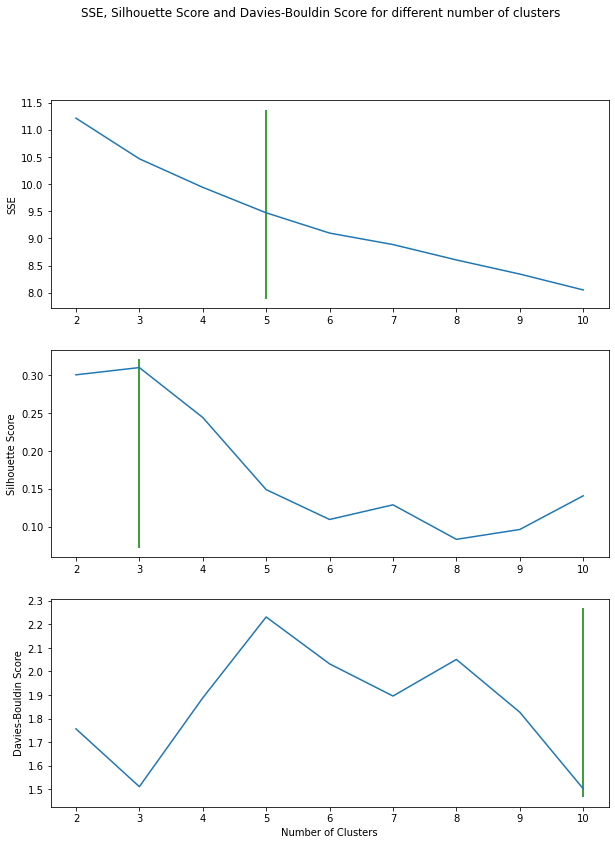

In [19]:
features = toronto_grouped.drop(columns=['Neighborhood Name'])
elbow_optimal_k, silhouette_optimal_k, db_optimal_k = optimal_k(features, kmeans_kwargs= kmeans_kwargs)

Based on the above figure, elbow is not clear and sharp. Therefore the optimal k from the elbow method is ambiguous. 

Both Silhouette Score and Davies Bouldin Score suggest that `k = 3` is optimal number of clusters for K-Means

The minimum of Davies Bouldin Score is where `k = 10` but this scenario likely leads to model over-fitting.

Therefore, we will choose the number of clusters as Silhouette optimal k (`k = 3`)

In [20]:
# set number of clusters
n_clusters = silhouette_optimal_k
# run k-means clustering
kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs).fit(features)

### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [21]:
neighborhood_top10_venues= top_n_venues_in_neighborhood(toronto_grouped, 10)
neighborhood_top10_venues.insert(1, 'Cluster Labels', kmeans.labels_)
neighborhood_top10_venues.head()

,Neighborhood Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,0,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",0,Pizza Place,Coffee Shop,Sandwich Place,Gas Station,Convenience Store,Pub,Playground,Dance Studio,Gym,Dim Sum Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",0,Bank,Coffee Shop,Pizza Place,Supermarket,Bridal Shop,Shopping Mall,Sandwich Place,Restaurant,Pharmacy,Pet Store
3,Bayview Village,0,Intersection,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",0,Italian Restaurant,Coffee Shop,Sandwich Place,Greek Restaurant,Bagel Shop,Bakery,Sushi Restaurant,Juice Bar,Fast Food Restaurant,Liquor Store


In [22]:
toronto_clusters_and_top10_venues = toronto_neighborhoods.join(neighborhood_top10_venues.set_index('Neighborhood Name'), on='Neighborhood', how='right')
toronto_clusters_and_top10_venues['Cluster Labels'].astype(int)
toronto_clusters_and_top10_venues.reset_index(drop=True, inplace=True)
toronto_clusters_and_top10_venues.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1S,Scarborough,Agincourt,43.794200,-79.262029,0,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
1,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,0,Pizza Place,Coffee Shop,Sandwich Place,Gas Station,Convenience Store,Pub,Playground,Dance Studio,Gym,Dim Sum Restaurant
2,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0,Bank,Coffee Shop,Pizza Place,Supermarket,Bridal Shop,Shopping Mall,Sandwich Place,Restaurant,Pharmacy,Pet Store
3,M2K,North York,Bayview Village,43.786947,-79.385975,0,Intersection,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
4,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,0,Italian Restaurant,Coffee Shop,Sandwich Place,Greek Restaurant,Bagel Shop,Bakery,Sushi Restaurant,Juice Bar,Fast Food Restaurant,Liquor Store


### Finally, let's visualize the resulting clusters

In [23]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_clusters_and_top10_venues['Latitude'], 
                                  toronto_clusters_and_top10_venues['Longitude'], 
                                  toronto_clusters_and_top10_venues['Neighborhood'], 
                                  toronto_clusters_and_top10_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 3. Examine Clusters

### Cluster 1:

In [24]:
toronto_clusters_and_top10_venues.set_index('Cluster Labels').loc[0]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0,M1S,Scarborough,Agincourt,43.794200,-79.262029,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
0,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,Pizza Place,Coffee Shop,Sandwich Place,Gas Station,Convenience Store,Pub,Playground,Dance Studio,Gym,Dim Sum Restaurant
0,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,Bank,Coffee Shop,Pizza Place,Supermarket,Bridal Shop,Shopping Mall,Sandwich Place,Restaurant,Pharmacy,Pet Store
0,M2K,North York,Bayview Village,43.786947,-79.385975,Intersection,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
0,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,Italian Restaurant,Coffee Shop,Sandwich Place,Greek Restaurant,Bagel Shop,Bakery,Sushi Restaurant,Juice Bar,Fast Food Restaurant,Liquor Store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,M9P,Etobicoke,Westmount,43.696319,-79.532242,Pizza Place,Ice Cream Shop,Coffee Shop,Chinese Restaurant,Sandwich Place,Discount Store,Middle Eastern Restaurant,Supermarket,Flea Market,Intersection
0,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849,Grocery Store,Pizza Place,Coffee Shop,Bakery,Asian Restaurant,Gas Station,Korean Restaurant,Seafood Restaurant,Fish Market,Intersection
0,M2N,North York,Willowdale South,43.770120,-79.408493,Coffee Shop,Ramen Restaurant,Korean Restaurant,Pizza Place,Shopping Mall,Bank,Sushi Restaurant,Fast Food Restaurant,Café,Pet Store


This cluster contains neighborhoods where most common venues including Restaurant, Shop, Grocery Store, etc.

### Cluster 2: 

In [25]:
toronto_clusters_and_top10_venues.set_index('Cluster Labels').loc[1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
1,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,Baseball Field,Construction & Landscaping,Electronics Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Bar,Construction & Landscaping,Yoga Studio,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant


This cluster contains neighborhoods where most common venues including construction & lanscapting, dumpling restaurant, Eastern European restaurant, etc.

### Cluster 3: 

In [26]:
toronto_clusters_and_top10_venues.set_index('Cluster Labels').loc[2,:]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
2,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,Park,Women's Store,Sporting Goods Shop,Gym,Bakery,Mexican Restaurant,Yoga Studio,Drugstore,Dive Bar,Dog Run
2,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,Discount Store,Bar,Park,Sandwich Place,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M3K,North York,"Downsview East , CFB Toronto",43.737473,-79.464763,Business Service,Airport,Park,Shoe Store,Yoga Studio,Drugstore,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
2,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307,Sushi Restaurant,Jewelry Store,Park,Trail,Drugstore,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
2,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,Field,Park,Hockey Arena,Trail,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run
2,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Swim School,Bus Line,Park,Yoga Studio,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,Park,Tennis Court,Gym,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
2,M6L,North York,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,Construction & Landscaping,Bakery,Park,Home Service,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
2,M3A,North York,Parkwoods,43.753259,-79.329656,Food & Drink Shop,Pet Store,Construction & Landscaping,Park,Yoga Studio,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop


This cluster contains neighborhoods where most common venues including park, trail, drung store.